In [1]:
import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pyproj import Proj, transform
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import dask.dataframe as dd
from rasterio.transform import from_origin
import numpy as np
import rasterio
import momepy
import pickle
from tqdm import tqdm
from dask.distributed import Client, LocalCluster
import dask
import dask.dataframe as dd

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

2023-12-21 22:02:28,784 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,789 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,794 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,799 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,803 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,807 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,814 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-21 22:02:28,818 - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34181,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:33651,Total threads: 2
Dashboard: http://127.0.0.1:42909/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:43689,


In [3]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [4]:
if lng:
    lon = lng

In [5]:
lonlat=(lon, lat)

In [6]:
buildings = gpd.read_parquet(f"../output/{place}/buildings_morphometric_var.pq")
tessellation = gpd.read_parquet(f"../output/{place}/tessellation_morphometric_var.pq")
edges = gpd.read_parquet(f"../output/{place}/edges.pq")
nodes = gpd.read_parquet(f"../output/{place}/nodes.pq")
stroke = gpd.read_parquet(f"../output/{place}/stroke_gdf.pq")

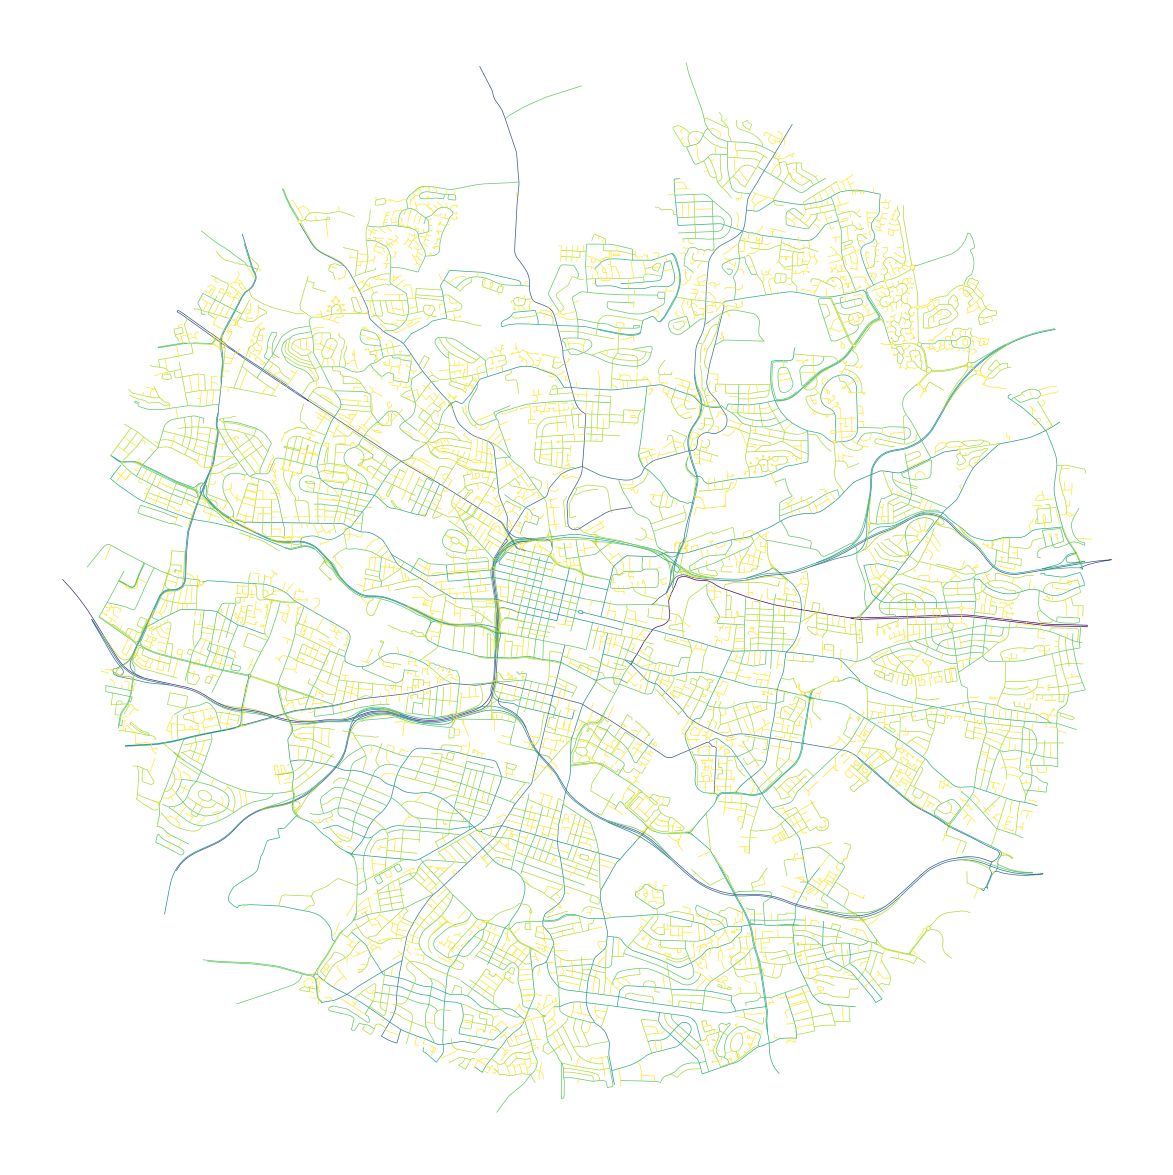

In [7]:
stroke.plot(stroke.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

In [8]:
stroke["stroke_length"] = stroke.length
stroke = stroke.drop(columns=["n_segments"])

## Linear Regression

In [9]:
nodes = nodes.drop(columns=["nodeID"])

In [10]:
edges = edges.drop(columns=["node_start", "node_end", "mm_len"])

In [11]:
merged_gdf = gpd.GeoDataFrame(buildings.merge(tessellation, on='uID', how='inner'), geometry="geometry_x")
merged_gdf = merged_gdf.sjoin_nearest(nodes, max_distance=1000, how="left").drop(columns=["index_right"])
merged_gdf = merged_gdf.sjoin_nearest(edges, max_distance=1000, how="left").drop(columns=["index_right"])
merged_gdf = merged_gdf.sjoin_nearest(stroke, max_distance=1000, how="left").drop(columns=["index_right"])

In [12]:
# Function to load a pickled object from a file
def load_pickled_object(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load the pickled objects
queen_3 = load_pickled_object(f"../output/{place}/queen_3.pkl")

In [13]:
queen_3_scattered = client.scatter(queen_3)
merged_gdf_scattered = client.scatter(merged_gdf)

In [19]:
merged_gdf["uID"]

0            0
1            1
2            2
3            3
4            4
         ...  
40931    40931
40932    40932
40933    40933
40934    40934
40935    40935
Name: uID, Length: 42465, dtype: int64

In [17]:
# Define a function to compute percentiles
def compute_percentiles(column_name, gdf, queen_3, uid):
    perc = momepy.Percentiles(gdf, column_name, queen_3, uid, verbose=False).frame
    perc.columns = [f"{column_name}_" + str(x) for x in perc.columns]
    return perc

# Use dask.delayed to parallelize
delayed_results = []
for column in merged_gdf.columns.drop(["uID", "geometry_x", "geometry_y"]):
    delayed_result = dask.delayed(compute_percentiles)(column, merged_gdf_scattered, queen_3_scattered, "uID")
    delayed_results.append(delayed_result)

# Compute the results in parallel
percentiles = dask.compute(*delayed_results)

# Optionally, you can concatenate the results back into a single DataFrame
final_result = pd.concat(percentiles, axis=1)

In [20]:
final_result["uID"] = merged_gdf["uID"]

In [23]:
final_result.to_parquet(f"../output/{place}/traditional_quantilisation.pq")

2023-12-21 22:55:28,118 - tornado.application - ERROR - Uncaught exception GET /profile/ws?key=start (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/profile/ws?key=start', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/tornado/web.py", line 3290, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
